# Import libraries

In [1]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role

In [2]:
role = get_execution_role()

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [3]:
bucket_name = 'sagemaker-employee' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')

In [4]:
data= pd.read_csv('s3://sagemaker-employee/HR-Employee-Attrition.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

There are no NULL values

# Data Visualization

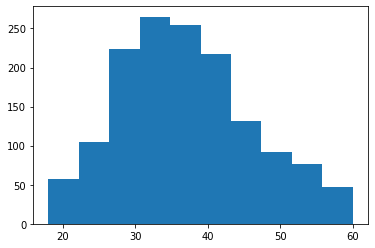

In [6]:
plt.hist(data['Age'])
plt.show()

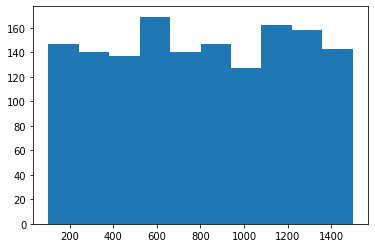

In [7]:
plt.hist(data['DailyRate'])
plt.show()

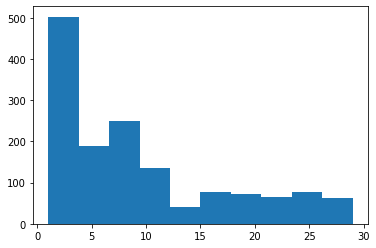

In [8]:
plt.hist(data['DistanceFromHome'])
plt.show()

In [9]:
data.shape

(1470, 35)

In [10]:
data['Over18'].value_counts()

Y    1470
Name: Over18, dtype: int64

In [11]:
data['StandardHours'].value_counts()

80    1470
Name: StandardHours, dtype: int64

In [12]:
data['EmployeeCount'].value_counts()

1    1470
Name: EmployeeCount, dtype: int64

these Over18, StandardHours, EmployeeCount have constant values and can be dropped.

In [13]:
data = data.drop(['Over18', 'StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis = 1)

In [14]:
data.shape

(1470, 31)

# Perform One Hot Encoding

In [15]:
data.loc[data['Attrition']=='No','Attrition'] = 0
data.loc[data['Attrition']=='Yes','Attrition'] = 1

In [16]:
data.loc[data['OverTime']=='No','OverTime'] = 0
data.loc[data['OverTime']=='Yes','OverTime'] = 1

In [17]:
data.loc[data['Gender']=='Male','Gender'] = 1
data.loc[data['Gender']=='Female','Gender'] = 0

In [18]:
data['Business_Travel_Rarely']=0
data['Business_Travel_Frequently']=0
data['Business_Non-Travel']=0

data.loc[data['BusinessTravel']=='Travel_Rarely','Business_Travel_Rarely'] = 1
data.loc[data['BusinessTravel']=='Travel_Frequently','Business_Travel_Frequently'] = 1
data.loc[data['BusinessTravel']=='Non-Travel','Business_Non-Travel'] = 1

In [19]:
data['Department_Sales']=0
data['Department_R&D']=0
data['Department_Dept_Human Resources'] =0

data.loc[data['Department']=='Sales','Department_Sales'] = 1
data.loc[data['Department']=='Research & Development','Department_R&D'] = 1
data.loc[data['Department']=='Human Resources','Department_Dept_Human Resources'] = 1

In [20]:
data['EducationField_Life Sciences']=0
data['EducationField_Medical']=0
data['EducationField_Marketing']=0
data['EducationField_Technical Degree']=0
data['EducationField_Education Human Resources']=0
data['EducationField_Education_Other']=0

data.loc[data['EducationField']=='Life Sciences','EducationField_Life Sciences'] = 1
data.loc[data['EducationField']=='Medical','EducationField_Medical'] = 1
data.loc[data['EducationField']=='Other','EducationField_Education_Other'] = 1
data.loc[data['EducationField']=='Technical Degree','EducationField_Technical Degree'] = 1
data.loc[data['EducationField']=='Human Resources','EducationField_Education Human Resources'] = 1
data.loc[data['EducationField']=='Marketing','EducationField_Marketing'] = 1

In [21]:
data['JobRole_Research Scientist']=0
data['JobRole_Laboratory Technician']=0
data['JobRole_Sales Executive']=0
data['JobRole_Manufacturing Director']=0
data['JobRole_Healthcare Representative']=0
data['JobRole_Sales Representative']=0
data['JobRole_Research Director']=0
data['JobRole_Manager'] = 0
data['JobRole_Job_Human_Resources'] = 0

data.loc[data['JobRole']=='Research Scientist','JobRole_Research Scientist'] = 1
data.loc[data['JobRole']=='Laboratory Technician','JobRole_Laboratory Technician'] = 1
data.loc[data['JobRole']=='Sales Executive','JobRole_Sales Executive'] = 1
data.loc[data['JobRole']=='Sales Representative','JobRole_Sales Representative'] = 1
data.loc[data['JobRole']=='Manufacturing Director','JobRole_Manufacturing Director'] = 1
data.loc[data['JobRole']=='Healthcare Representative','JobRole_Healthcare Representative'] = 1
data.loc[data['JobRole']=='Research Director','JobRole_Research Director'] = 1
data.loc[data['JobRole']=='Manager','JobRole_Manager'] = 1
data.loc[data['JobRole']=='Human Resources','JobRole_Job_Human_Resources'] = 1

In [22]:
data['MaritalStatus_Single']=0
data['MaritalStatus_Married']=0
data['MaritalStatus_Divorced']=0

data.loc[data['MaritalStatus']=='Married','MaritalStatus_Married'] = 1
data.loc[data['MaritalStatus']=='Single','MaritalStatus_Single'] = 1
data.loc[data['MaritalStatus']=='Divorced','MaritalStatus_Divorced'] = 1


In [23]:
data = data.drop(['BusinessTravel','EducationField',
                        'Department','JobRole','MaritalStatus'],axis=1)
data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Sales Executive,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Sales Representative,JobRole_Research Director,JobRole_Manager,JobRole_Job_Human_Resources,MaritalStatus_Single,MaritalStatus_Married,MaritalStatus_Divorced
0,41,1,1102,1,2,2,0,94,3,2,...,1,0,0,0,0,0,0,1,0,0
1,49,0,279,8,1,3,1,61,2,2,...,0,0,0,0,0,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,...,0,0,0,0,0,0,0,1,0,0
3,33,0,1392,3,4,4,0,56,3,1,...,0,0,0,0,0,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,...,0,0,0,0,0,0,0,0,1,0


In [24]:
data.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Business_Travel_Rarely',
       'Business_Travel_Frequently', 'Business_Non-Travel', 'Department_Sales',
       'Department_R&D', 'Department_Dept_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Medical',
       'EducationField_Marketing', 'EducationField_Technical Degree',
       'EducationField_Education Human Resources',
       'EducationField_Education_Other', 'JobRole_Research Scientist',
       'JobRole_Laboratory Technician', 'Jo

# Building the model

In [25]:
from sklearn.model_selection import train_test_split

train_x = data.drop(['PerformanceRating'],axis=1)
train_y = data['PerformanceRating']
train_x.insert(0, 'PerformanceRating', train_y)

X,test_x,Y,test_y = train_test_split(train_x, train_y, test_size=0.2,random_state=42)

In [26]:
train_x.head()

,PerformanceRating,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Sales Executive,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Sales Representative,JobRole_Research Director,JobRole_Manager,JobRole_Job_Human_Resources,MaritalStatus_Single,MaritalStatus_Married,MaritalStatus_Divorced
0,3,41,1,1102,1,2,2,0,94,3,...,1,0,0,0,0,0,0,1,0,0
1,4,49,0,279,8,1,3,1,61,2,...,0,0,0,0,0,0,0,0,1,0
2,3,37,1,1373,2,2,4,1,92,2,...,0,0,0,0,0,0,0,1,0,0
3,3,33,0,1392,3,4,4,0,56,3,...,0,0,0,0,0,0,0,0,1,0
4,3,27,0,591,2,1,1,1,40,3,...,0,0,0,0,0,0,0,0,1,0


In [27]:
train_x.to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join('train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/train'.format(bucket_name), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [28]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(containers[my_region],role, train_instance_count=1, train_instance_type='ml.m5.large',output_path='s3://{}/output'.format(bucket_name),sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [29]:
xgb.set_hyperparameters(objective="multi:softmax",colsample_bytree= 0.5 ,learning_rate= 0.075,
                max_depth=5, alpha= 8, num_round=100,num_class=5)

In [30]:
xgb.fit({'train': s3_input_train})

2020-10-03 17:09:55 Starting - Starting the training job...
2020-10-03 17:09:57 Starting - Launching requested ML instances......
2020-10-03 17:11:06 Starting - Preparing the instances for training...
2020-10-03 17:11:51 Downloading - Downloading input data
2020-10-03 17:11:51 Training - Downloading the training image...
2020-10-03 17:12:25 Training - Training image download completed. Training in progress..Arguments: train
[2020-10-03:17:12:25:INFO] Running standalone xgboost training.
[2020-10-03:17:12:25:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-10-03:17:12:25:INFO] File size need to be processed in the node: 0.16mb. Available memory size in the node: 171.71mb
[2020-10-03:17:12:25:INFO] Determined delimiter of CSV input is ','
[17:12:25] S3DistributionType set as FullyReplicated
[17:12:25] 1470x49 matrix with 72030 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[17:12:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

# Deploy model

In [31]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m5.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [32]:
test_data_array = test_x.drop(['PerformanceRating'],axis=1).values
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(294,)


# Evaluate Model

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_y,predictions_array))
rmse

0.1749635530559413

# Delete Endpoint

In [ ]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)